## Convolutional Neural Network - Celeb Dataset

In [1]:
from IPython.display import Image as IPythonImage
%matplotlib inline
from IPython.core.display import display

In [2]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

In [3]:
!ls -ld

drwxr-xr-x 1 root root 4096 Mar  4 14:26 .


In [8]:
!mkdir data_faces

mkdir: cannot create directory ‘data_faces’: File exists
drwxr-xr-x 1 root root 4096 Mar  6 14:51 .


In [46]:
# downloading images of celebs
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip


--2025-03-06 15:25:52--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.128, 52.219.112.232, 52.219.117.40, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  9.56MB/s    in 78s     

2025-03-06 15:27:10 (17.7 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [48]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [61]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(f"number of images: {len(img_list)}")

number of images: 202599


In [24]:
# Download all files (features/labels and other information) from a Google Drive folder (should be publicly visible)
!gdown --folder https://drive.google.com/drive/folders/1zIhmZAbpt9R3aM09wu3J1CixK0kluwMb -O data_faces/



Retrieving folder contents
Processing file 1W6PUogOswAGjWc3TS6acWewkGw7v72VO identity_CelebA.txt
Processing file 1bXoazwXbKK2dWxu_skhwv156Uq-gNZGe list_attr_celeba.txt
Processing file 1RE8Ojs0gs8BxPxd7ZtbmE7-_lZT1wNHK list_bbox_celeba.txt
Processing file 1xojfv4rXGdR7TB7-peFPrUFY-MLZQa3m list_eval_partition.txt
Processing file 18OZpHkC4Bpi2YMnewN9yriwLogAiVrsP list_landmarks_align_celeba.txt
Processing file 1Uh_UHnkJmmkPuYPmiKYcp2Ookum6JHEI list_landmarks_celeba.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1W6PUogOswAGjWc3TS6acWewkGw7v72VO
To: /content/data_faces/copied_celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 17.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bXoazwXbKK2dWxu_skhwv156Uq-gNZGe
To: /content/data_faces/copied_celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R

In [20]:
!ls -lrth ./data_faces/

total 4.0K
drwxr-xr-x 2 root root 4.0K Mar  6 14:54 copied_celeba


In [21]:
# Move all files from copied_celeba to the data_faces root folder
!mv data_faces/copied_celeba/* data_faces/

In [35]:
# Remove the empty copied_celeba folder
!rm -r data_faces/copied_celeba



In [23]:
!ls data_faces/

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


**class to create torchvision objects**

In [25]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CelebADataset(Dataset):
    def __init__(self, image_ids, attr_labels, img_folder, transform=None):
        self.image_ids = image_ids.tolist()  # Convert Pandas series to list to avoid .iloc issues
        self.attr_labels = attr_labels.to_numpy()  # Convert Pandas dataframe to NumPy array for easier indexing
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Load image using list indexing
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_folder, img_id)
        image = Image.open(img_path)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Access label from the NumPy array (direct indexing)
        label = self.attr_labels[idx]  # Access the label using normal NumPy indexing

        return image, label


In [37]:
!ls -l /content/data_faces/

total 62092
-rw-r--r-- 1 root root  3424458 Oct  3 14:27 identity_CelebA.txt
-rw-r--r-- 1 root root 26721026 Oct  3 14:27 list_attr_celeba.txt
-rw-r--r-- 1 root root  6082035 Oct  3 14:27 list_bbox_celeba.txt
-rw-r--r-- 1 root root  2836386 Oct  3 14:27 list_eval_partition.txt
-rw-r--r-- 1 root root 12156055 Oct  3 14:27 list_landmarks_align_celeba.txt
-rw-r--r-- 1 root root 12352635 Oct  3 14:27 list_landmarks_celeba.txt


In [39]:
!head /content/data_faces/list_attr_celeba.txt

202599
5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 
000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1
000002.jpg -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
000003.jpg -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
000004.jpg -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1  1
0000

In [40]:
!head /content/data_faces/list_eval_partition.txt

000001.jpg 0
000002.jpg 0
000003.jpg 0
000004.jpg 0
000005.jpg 0
000006.jpg 0
000007.jpg 0
000008.jpg 0
000009.jpg 0
000010.jpg 0


In [41]:
!head /content/data_faces/identity_CelebA.txt

000001.jpg 2880
000002.jpg 2937
000003.jpg 8692
000004.jpg 5805
000005.jpg 9295
000006.jpg 4153
000007.jpg 9040
000008.jpg 6369
000009.jpg 3332
000010.jpg 612


In [62]:
# Path to your dataset folder
image_path = "/content/data_faces"
img_folder = os.path.join(image_path, 'img_align_celeba') #img_align_celeba

# Paths to the required files
attr_file = os.path.join(image_path, 'list_attr_celeba.txt')
partition_file = os.path.join(image_path, 'list_eval_partition.txt')

# Step 1: Load the attributes and partition data
attributes = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
partition = pd.read_csv(partition_file, delim_whitespace=True, header=None, names=['image_id', 'partition'])

# Step 2: Filter for the 'Smiling' attribute (32nd column)
smiling_attr = attributes[['Smiling']]  # The "Smiling" attribute is already labeled
smiling_attr = smiling_attr.applymap(lambda x: 1 if x == 1 else 0)  # Convert -1 to 0 for binary classification

# Step 3: Split the dataset into train, validation, and test sets based on partition file
train_data = partition[partition['partition'] == 0]  # Train set
valid_data = partition[partition['partition'] == 1]  # Validation set
test_data = partition[partition['partition'] == 2]   # Test set

# Extract the image ids and corresponding labels (Smiling or not)
train_labels = smiling_attr.loc[train_data['image_id']]
valid_labels = smiling_attr.loc[valid_data['image_id']]
test_labels = smiling_attr.loc[test_data['image_id']]

# Step 4: Create Transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Step 5: Create Dataset Objects using the custom CelebADataset class
celeba_train_dataset = CelebADataset(train_data['image_id'], train_labels['Smiling'], img_folder, transform)
celeba_valid_dataset = CelebADataset(valid_data['image_id'], valid_labels['Smiling'], img_folder, transform)
celeba_test_dataset = CelebADataset(test_data['image_id'], test_labels['Smiling'], img_folder, transform)

# Print the dataset sizes
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))


<ipython-input-62-5b2fa53d6678>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attributes = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
<ipython-input-62-5b2fa53d6678>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  partition = pd.read_csv(partition_file, delim_whitespace=True, header=None, names=['image_id', 'partition'])
<ipython-input-62-5b2fa53d6678>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  smiling_attr = smiling_attr.applymap(lambda x: 1 if x == 1 else 0)  # Convert -1 to 0 for binary classification


Train set: 162770
Validation set: 19867
Test set: 19962


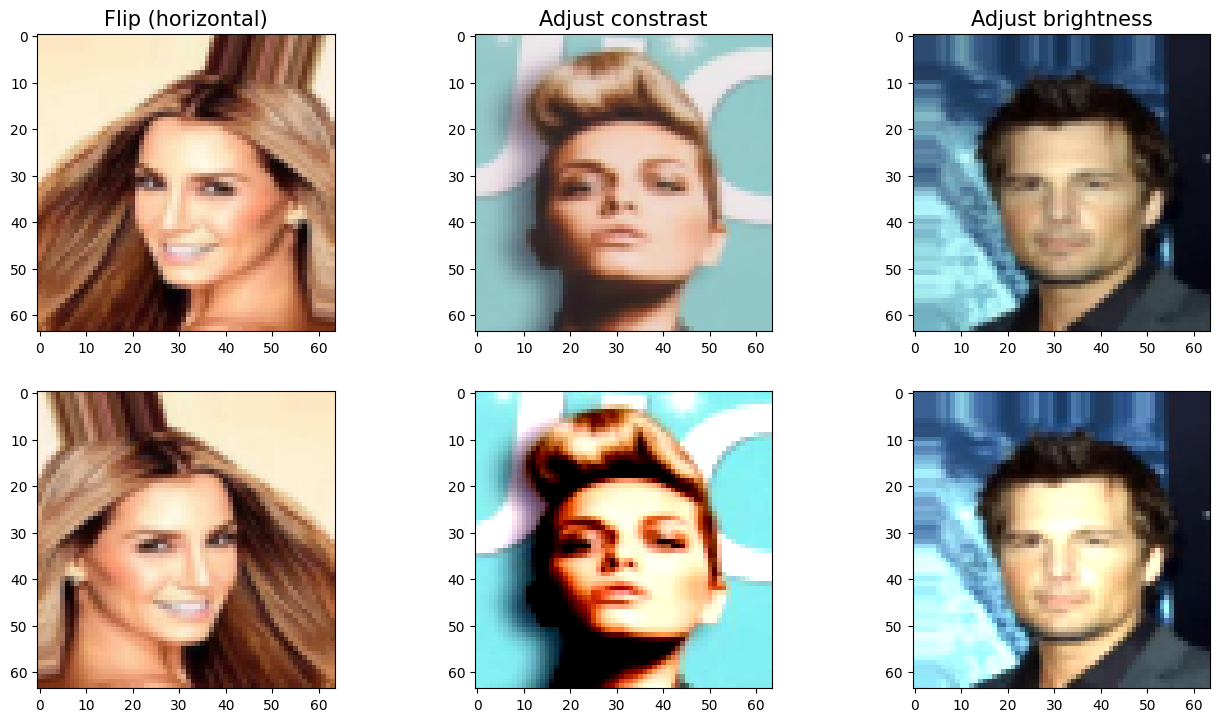

In [73]:
import torchvision.transforms.functional as F

## take 3 examples

fig = plt.figure(figsize=(16, 8.5))




## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 3, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Flip (horizontal)', size=15)
imgtmp = img.permute(1, 2, 0) #Permutes the dimensions of the image tensor. PyTorch images are typically stored as (C, H, W). Matplotlib expects images in (H, W, C) format.
ax.imshow(imgtmp)
ax = fig.add_subplot(2, 3, 4)
img_flipped = transforms.functional.hflip(img)
img_flipped = img_flipped.permute(1, 2, 0)
ax.imshow(img_flipped)


## Column 3: adjust contrast
ax = fig.add_subplot(2, 3, 2)
img, attr = celeba_train_dataset[4]
imgtmp = img.permute(1, 2, 0)
ax.set_title('Adjust constrast', size=15)
ax.imshow(imgtmp)
ax = fig.add_subplot(2, 3, 5)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
img_adj_contrast = img_adj_contrast.permute(1, 2, 0)
ax.imshow(img_adj_contrast)


## Column 4: adjust brightness
ax = fig.add_subplot(2, 3, 3)
img, attr = celeba_train_dataset[5555]
ax.set_title('Adjust brightness', size=15)
imgtmp = img.permute(1, 2, 0)
ax.imshow(imgtmp)
ax = fig.add_subplot(2, 3, 6)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
img_adj_brightness = img_adj_brightness.permute(1, 2, 0)
ax.imshow(img_adj_brightness)





In [74]:
celeba_train_dataset

In [77]:
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) # Subset allows you to create a smaller subset of a dataset by specifying indices.
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

In [78]:
len(celeba_train_dataset)

16000

In [79]:
celeba_train_dataset

In [80]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(celeba_train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(celeba_valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(celeba_test_dataset, batch_size=2, shuffle=False)

# Now you can use train_loader, valid_loader, and test_loader for your model training/evaluation


In [ ]:
for img_batch, label_batch in train_loader:
    print("Batch of images:", img_batch.shape)
    print("Batch of labels:", label_batch.shape)
    break


Batch of images: torch.Size([2, 3, 64, 64])
Batch of labels: torch.Size([2])


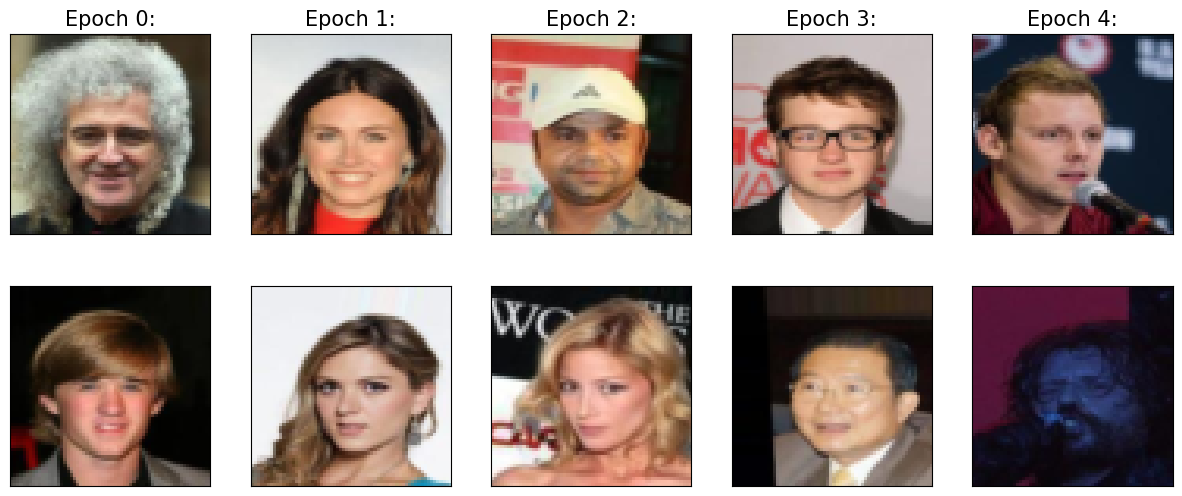

In [83]:
# Showing some random images

import matplotlib.pyplot as plt

# Create a figure for plotting
fig = plt.figure(figsize=(15, 6))

# Number of epochs (times to visualize the batch)
num_epochs = 5

# Loop through epochs
for j in range(num_epochs):

    # Get a batch of images and labels from the train_loader
    img_batch, label_batch = next(iter(train_loader))

    # Ensure you have enough images in the batch (batch size is 2)
    if img_batch.shape[0] < 2:
        continue  # Skip if the batch size is smaller than 2

    # First image in the batch
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)

    # Convert the image to (H, W, C) format and display
    ax.imshow(img.permute(1, 2, 0))

    # Second image in the batch
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])

    # Convert the image to (H, W, C) format and display
    ax.imshow(img.permute(1, 2, 0))

plt.show()


### Training a Deep Convolutional Neural Network

In [84]:
torch.manual_seed(1)

# Create DataLoaders
batch_size = 64

train_dl = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
# CHECK 1
# Get the first image and label from the training dataset
img, label = celeba_train_dataset[0]

# Print the shape of the image tensor
print(f"Image shape: {img.shape}")
print(f"Label: {label}")


Image shape: torch.Size([3, 64, 64])
Label: 1


In [86]:
# CHECK 2

# Get the first batch of images and labels from the train_loader
img_batch, label_batch = next(iter(train_dl))

# Print the shape of the image batch and label batch
print(f"Image batch shape: {img_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")


Image batch shape: torch.Size([64, 3, 64, 64])
Label batch shape: torch.Size([64])


In [87]:
import torch.nn as nn

# Define the model
def MyModel():
    model = nn.Sequential()

    # Add layers to the model
    model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
    model.add_module('relu1', nn.ReLU())
    model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
    model.add_module('dropout1', nn.Dropout(p=0.5))

    model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
    model.add_module('relu2', nn.ReLU())
    model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
    model.add_module('dropout2', nn.Dropout(p=0.5))

    model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
    model.add_module('relu3', nn.ReLU())
    model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
    model.add_module('relu4', nn.ReLU())

    #x = torch.ones((4, 3, 64, 64))
    #model(x).shape

    model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
    model.add_module('flatten', nn.Flatten())

    #x = torch.ones((4, 3, 64, 64))
    #model(x).shape

    model.add_module('fc', nn.Linear(256, 1))
    model.add_module('sigmoid', nn.Sigmoid())

    #x = torch.ones((4, 3, 64, 64))
    #model(x).shape

    return model


In [98]:
model = MyModel()
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [99]:
# testing dimensions

x = torch.ones((4, 3, 64, 64)) # tensor representing a batch of 4 fake images each (CxHxW) =(3x64x64)

print(model(x).shape)

print(model(x)[:, 0])


torch.Size([4, 1])
tensor([0.4876, 0.4875, 0.4870, 0.4879], grad_fn=<SelectBackward0>)


In [ ]:
#----------------------------------------------------------------------------------------------------------

In [100]:
device = torch.device("cuda:0")
#device = torch.device("cpu")
model = model.to(device)

In [101]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#----------------------------------------------------------------------------------------------------------

In [102]:
def train(model, num_epochs, train_dl, valid_dl):

    model.train()

    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs



    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)


        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [103]:
def reinitialize_model_optimizer():
    model = MyModel()  # Replace with your model definition
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Replace with your optimizer
    return model, optimizer

In [104]:
model, optimizer = reinitialize_model_optimizer()
model = model.to(device)

In [105]:
# Now proceed with the training
num_epochs = 20
# Use the corrected model and optimizer
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5176 val_accuracy: 0.5410
Epoch 2 accuracy: 0.5332 val_accuracy: 0.5290
Epoch 3 accuracy: 0.5533 val_accuracy: 0.6080
Epoch 4 accuracy: 0.5838 val_accuracy: 0.5960
Epoch 5 accuracy: 0.6151 val_accuracy: 0.6330
Epoch 6 accuracy: 0.6377 val_accuracy: 0.6370
Epoch 7 accuracy: 0.6568 val_accuracy: 0.6810
Epoch 8 accuracy: 0.7138 val_accuracy: 0.7400
Epoch 9 accuracy: 0.7474 val_accuracy: 0.7620
Epoch 10 accuracy: 0.7729 val_accuracy: 0.7880
Epoch 11 accuracy: 0.7909 val_accuracy: 0.8000
Epoch 12 accuracy: 0.8158 val_accuracy: 0.8310
Epoch 13 accuracy: 0.8241 val_accuracy: 0.8370
Epoch 14 accuracy: 0.8349 val_accuracy: 0.8540
Epoch 15 accuracy: 0.8426 val_accuracy: 0.8210
Epoch 16 accuracy: 0.8496 val_accuracy: 0.8330
Epoch 17 accuracy: 0.8514 val_accuracy: 0.8630
Epoch 18 accuracy: 0.8530 val_accuracy: 0.8670
Epoch 19 accuracy: 0.8604 val_accuracy: 0.8590
Epoch 20 accuracy: 0.8614 val_accuracy: 0.8600


In [ ]:
!ls

celeba.zip  data_faces	drive  sample_data


In [ ]:
!ls -lrth

total 1.4G
-rw-r--r-- 1 root root 1.4G Apr 21  2017 celeba.zip
drwxr-xr-x 1 root root 4.0K Oct  4 13:23 sample_data
drwx------ 6 root root 4.0K Oct  8 02:17 drive
drwxr-xr-x 3 root root 4.0K Oct  8 02:17 data_faces
-rw-r--r-- 1 root root 4.5M Oct  8 02:38 checkpoint.pth


In [ ]:
#----------------------------------------------------------------------------------------------#

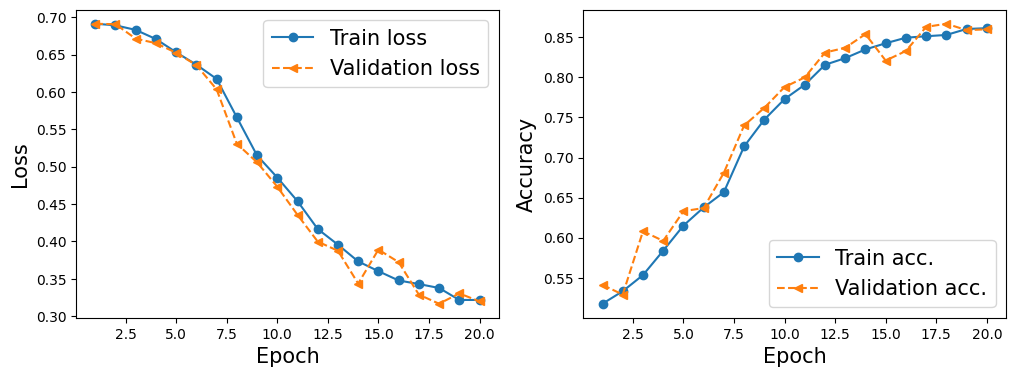

In [106]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


plt.show()

In [107]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8650


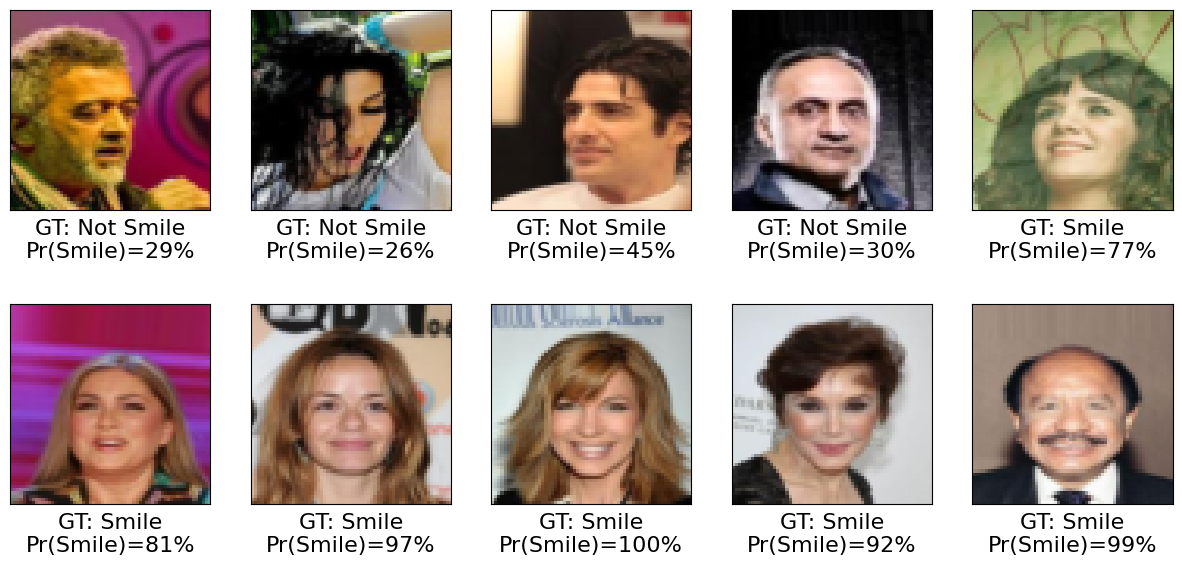

In [108]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

plt.show()

* The above is just a starting point.

* With some modifications, you should be able to get results similar to the following images

In [ ]:
from IPython.display import Image, display


# FIG 1
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig1_dcnn2.png", width=600))
# FIG 2
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig2_dcnn2.png", width=600))